In [2]:
import os
import sys
import cortex
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import pandas as pd
import torch
import seaborn as sns
import nibabel as nib
import pickle
import torchvision.models as models
import nibabel as nib
import h5py
import scipy.stats.mstats as mstats
import matplotlib.patches as patches
import copy
import yaml
import joblib

from nilearn import plotting
from scipy.ndimage import binary_dilation
from PIL import Image
from importlib import reload
from scipy.io import loadmat
from matplotlib.ticker import MultipleLocator, NullFormatter
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from colorama import Fore, Style
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colormaps
from torch.utils.data import Dataset, DataLoader
from torch.nn import Module
from torchvision import transforms
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.impute import SimpleImputer
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from tqdm import tqdm
from matplotlib.lines import Line2D
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from math import sqrt
from typing import Dict, Tuple, Union
from scipy.special import softmax
from scipy.stats import zscore as zs

print(sys.path)
%pwd

os.chdir('/home/rfpred')
sys.path.append('/home/rfpred/')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode')

from unet_recon.inpainting import UNet
from funcs.analyses import univariate_regression

['/home/rfpred/notebooks/clean', '/home/rfpred/envs/rfenv/lib/python311.zip', '/home/rfpred/envs/rfenv/lib/python3.11', '/home/rfpred/envs/rfenv/lib/python3.11/lib-dynload', '', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages', '/home/rfpred/notebooks/alien_nbs/lgnpy', '/home/rfpred', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode']


In [32]:
def reload_nsp():
    import funcs.natspatpred
    importlib.reload(funcs.natspatpred)
    from funcs.natspatpred import NatSpatPred, VoxelSieve
    NSP = NatSpatPred()
    NSP.initialise()
    return NSP

# from lgnpy.CEandSC.lgn_statistics import lgn_statistics, loadmat, LGN
import importlib
from importlib import reload
import funcs.natspatpred
import unet_recon.inpainting

importlib.reload(funcs.natspatpred)
importlib.reload(unet_recon.inpainting)

from unet_recon.inpainting import UNet
from funcs.natspatpred import NatSpatPred, VoxelSieve

import lgnpy.CEandSC.lgn_statistics
from lgnpy.CEandSC.lgn_statistics import lgn_statistics, loadmat, LGN


def reload_lgn(config_file:(str | None)=None):

    import lgnpy.CEandSC.lgn_statistics

    importlib.reload(lgnpy.CEandSC.lgn_statistics)
    from lgnpy.CEandSC.lgn_statistics import lgn_statistics, loadmat, LGN

    if config_file is None:
        config_path = (
            "/home/rfpred/notebooks/alien_nbs/lgnpy/lgnpy/CEandSC/default_config.yml"
        )
    else:
        config_path = f'/home/rfpred/notebooks/alien_nbs/lgnpy/lgnpy/CEandSC/{config_file}'

    with open(config_path, "r") as f:
        config = yaml.load(f, Loader=yaml.UnsafeLoader)

    lgn = LGN(config=config, default_config_path=config_path)
    threshold_lgn = loadmat(
        filepath="/home/rfpred/notebooks/alien_nbs/lgnpy/ThresholdLGN.mat"
    )["ThresholdLGN"]

    return lgn

NSP = NatSpatPred()
NSP.initialise()

soepstengesl
Naturalistic Spatial Prediction class: Initialised

Class contains the following attributes:
 .analyse
 .attributes
 .cortex
 .datafetch
 .explore
 .hidden_methods
 .initialise
 .nsd_datapath
 .own_datapath
 .stimuli
 .subjects
 .utils


In [2]:
from funcs.imgproc import get_imgs_designmx, rms_all, feature_df, show_stim, get_rms_contrast, get_rms_contrast_lab, get_contrast_df, get_img_prf, get_visfeature_dict
from funcs.rf_tools import get_mask, css_gaussian_cut, make_circle_mask, make_visrois_dict, write_prf_dict
from funcs.utility import print_dict_structure, print_large, get_zscore, hypotheses_plot, multiple_regression
from funcs.analyses import multivariate_regression, regression_dict_multivariate, plot_roi_beta_distribution, get_hrf_dict
from funcs.utility import numpy2coords, coords2numpy, filter_array_by_size, find_common_rows
# from funcs.viscontrasts import lgn_statistics
from notebooks.alien_nbs.lgnpy.lgnpy.CEandSC import lgn_statistics

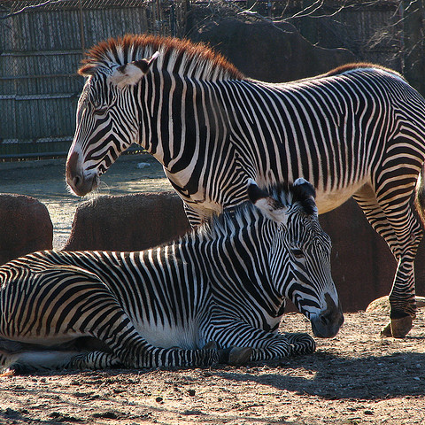

In [39]:
imgs, masks, img_nos = NSP.stimuli.rand_img_list(n_imgs=10,
                                                 asPIL=True,
                                                 add_masks=True,
                                                 mask_loc='center',
                                                 ecc_max=1,
                                                 select_ices=NSP.stimuli.imgs_designmx()['subj01'][:10])

imgs[5]

In [28]:
# deg_per_pixel=pix2hoek(2, 58.67, 2560, 50)
deg_per_pixel = 8.4 / 425
lgn = reload_lgn(config_file='default_config.yml')
patch_center = NSP.utils.get_circle_center(np.array(masks[0]))

In [40]:
img_nos

[46002, 61882, 828, 67573, 16020, 40422, 51517, 62325, 50610, 55065]

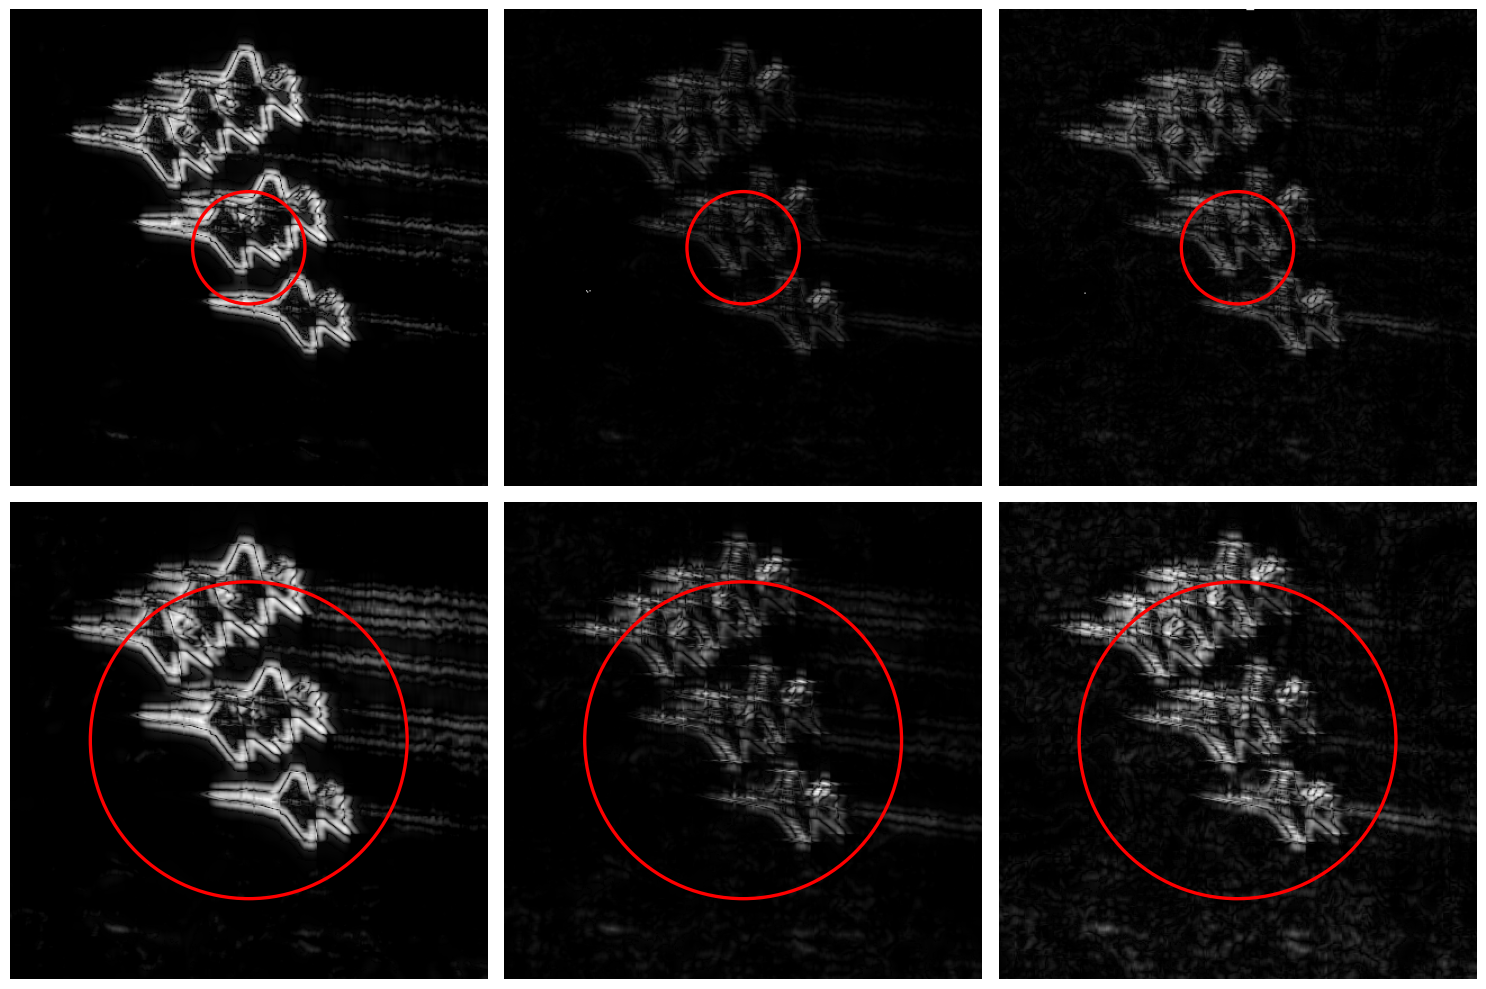

In [27]:

oeiloei = NSP.stimuli.get_scce_contrast(np.array(imgs[0]),
                                        plot="y",
                                        cmap="gist_gray",
                                        crop_prior=True,
                                        crop_post=False,
                                        save_plot=False,
                                        return_imfovs=True,
                                        imfov_overlay=True,
                                        config_path="/home/rfpred/notebooks/alien_nbs/lgnpy/lgnpy/CEandSC/default_config.yml",
                                        lgn_instance=lgn,
                                        patch_center=patch_center,
                                        deg_per_pixel=deg_per_pixel
                                        )

In [44]:
scce_feats = pd.DataFrame(columns=['img_no', 'ce', 'sc'])

for img_no, img in enumerate(imgs):
        
    ce, sc, _,_,_,_,_ = NSP.stimuli.get_scce_contrast(np.array(imgs[img_no]),
                                            plot="n",
                                            cmap="gist_gray",
                                            crop_prior=True,
                                            crop_post=False,
                                            save_plot=False,
                                            return_imfovs=True,
                                            imfov_overlay=True,
                                            config_path="/home/rfpred/notebooks/alien_nbs/lgnpy/lgnpy/CEandSC/default_config.yml",
                                            lgn_instance=lgn,
                                            patch_center=patch_center,
                                            deg_per_pixel=deg_per_pixel
                                            )
    # scce_feats = pd.concat([img_nos[img_no], ce, sc], axis=0)
    scce_feats.loc[len(scce_feats)] = [int(img_nos[img_no]), ce, sc]


In [49]:
df = pd.read_csv('/home/rfpred/data/custom_files/subj01/TESTINGscce_feats.csv')
df

,img_no,ce,sc
0,46002.0,0.001575,0.920782
1,61882.0,0.000059,0.546106
2,828.0,0.000067,NaN
3,67573.0,0.000162,0.907053
4,16020.0,0.000452,0.622739
5,40422.0,0.001769,1.146877
6,51517.0,0.000438,0.300512
7,62325.0,0.000106,0.268680
8,50610.0,0.003474,1.437567
9,55065.0,0.002100,2.205440


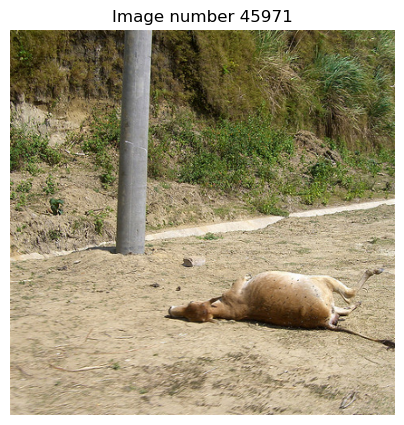

In [3]:
img = show_stim(small = 'y')

In [3]:
n_subjects = len(os.listdir('/home/rfpred/data/natural-scenes-dataset/nsddata/ppdata'))
vismask_dict = make_visrois_dict(vox_count = 'y', bin_check = 'n', n_subjects=n_subjects)
prf_dict = write_prf_dict(binary_masks = vismask_dict)

Subject 1
V1_mask
Non-zero voxels in V1_mask: 7887
V2_mask
Non-zero voxels in V2_mask: 8296
V3_mask
Non-zero voxels in V3_mask: 7022
V4_mask
Non-zero voxels in V4_mask: 3976
Subject 2
V1_mask
Non-zero voxels in V1_mask: 6476
V2_mask
Non-zero voxels in V2_mask: 6376
V3_mask
Non-zero voxels in V3_mask: 6236
V4_mask
Non-zero voxels in V4_mask: 2887
Subject 3
V1_mask
Non-zero voxels in V1_mask: 7358
V2_mask
Non-zero voxels in V2_mask: 6721
V3_mask
Non-zero voxels in V3_mask: 5316
V4_mask
Non-zero voxels in V4_mask: 2486
Subject 4
V1_mask
Non-zero voxels in V1_mask: 5119
V2_mask
Non-zero voxels in V2_mask: 5088
V3_mask
Non-zero voxels in V3_mask: 4669
V4_mask
Non-zero voxels in V4_mask: 2790
Subject 5
V1_mask
Non-zero voxels in V1_mask: 6502
V2_mask
Non-zero voxels in V2_mask: 6309
V3_mask
Non-zero voxels in V3_mask: 5383
V4_mask
Non-zero voxels in V4_mask: 3184
Subject 6
V1_mask
Non-zero voxels in V1_mask: 6479
V2_mask
Non-zero voxels in V2_mask: 6905
V3_mask
Non-zero voxels in V3_mask: 71

visfeats_rms = pd.read_pickle('./)

In [4]:
# Load in the RMS contrast values for each image, in and out inner circle
all_rms = pd.read_pickle('all_rms_lab_df')
all_irrelevant_rms = pd.read_pickle('all_rms_irrelevant_df.pkl')

In [12]:
# # Load in the design matrix
# dmx = get_imgs_designmx()

# # Subject specific object with the correct sequence of RMS contrast values per image.
# rms_subj01 = feature_df(subject = 'subj01', feature = 'rms', feat_per_img = all_rms, designmx = dmx) 
# rms_irrelevant_subj01 = feature_df(subject = 'subj01', feature = 'rms', feat_per_img = all_irrelevant_rms, designmx = dmx)
# # Write loop for all subjects

# # Standardize the root mean square values by turning them into z-scores
# rms_subj01_z = get_zscore(rms_subj01['rms'], print_ars = 'n')

# # Add the z-scored RMS contrast values to the dataframe
# if rms_subj01.shape[1] == 2:    
#     rms_subj01.insert(2,'rms_z', rms_subj01_z)

# print(rms_subj01)

# print(rms_subj01)
# print(rms_irrelevant_subj01)


This function I still have in here because I'll have to add the other visual features to it (SC , CE).

In [9]:
# Usage:
subjects = ['subj01', 'subj02', 'subj03', 'subj04', 'subj05', 'subj06', 'subj07', 'subj08']
dmx = get_imgs_designmx()
visfeats = get_visfeature_dict(subjects, all_rms, all_irrelevant_rms, dmx)

NameError: name 'all_rms' is not defined

In [2]:
import pandas as pd


In [6]:
all_rms_crop_prior = pd.read_pickle('/home/rfpred/all_rms_crop_prior_lab_df.pkl')
all_irrelevant_rms_crop_prior = pd.read_pickle('/home/rfpred/all_rms_crop_prior_irrel_lab_df.pkl')
subjects = ['subj01', 'subj02', 'subj03', 'subj04', 'subj05', 'subj06', 'subj07', 'subj08']
dmx = get_imgs_designmx()
visfeats_crop_prior = get_visfeature_dict(subjects, all_rms_crop_prior, all_irrelevant_rms_crop_prior, dmx)

Original array: 46002    25.918038
61882    24.401287
828      18.766712
67573    20.099196
16020    12.632245
           ...    
13773    18.510562
66767     8.810652
53167    20.633829
1943     21.634250
5033     15.231186
Name: rms, Length: 30000, dtype: float64
Z-scores: 46002    0.752011
61882    0.567996
828     -0.115602
67573    0.046058
16020   -0.859847
           ...   
13773   -0.146678
66767   -1.323490
53167    0.110921
1943     0.232294
5033    -0.544539
Name: rms, Length: 30000, dtype: float64
Original array: 46002    25.918038
61882    24.401287
828      18.766712
67573    20.099196
16020    12.632245
           ...    
13773    18.510562
66767     8.810652
53167    20.633829
1943     21.634250
5033     15.231186
Name: rms, Length: 30000, dtype: float64
Centered data: 46002     6.198476
61882     4.681725
828      -0.952850
67573     0.379634
16020    -7.087317
           ...    
13773    -1.209000
66767   -10.908910
53167     0.914267
1943      1.914688
5033     -4.48

### Okay this is super nice, now I need to first run a regression with the irrleevant RMS values, then I'm going to have to look at a larger central patch, so back to the pRF selection table, and then I'll have to figure out how to get SC and CE, also make everything more streamlined.

In [21]:
# with open('./data/custom_files/all_visfeats_rms_crop_prior.pkl', 'wb') as fp:
#     pickle.dump(visfeats_crop_prior, fp)
#     print('dictionary saved successfully to file')

# Load in the saved file
with open('./data/custom_files/all_visfeats_rms_crop_prior.pkl', 'rb') as fp:
   visfeats_crop_prior1 = pickle.load(fp)
   
print(visfeats_crop_prior1['subj01']['rms'])

print(visfeats)

       img_no        rms     rms_z     rms_mc
0       46002  25.918038  0.752011   6.198476
1       61882  24.401287  0.567996   4.681725
2         828  18.766712 -0.115602  -0.952850
3       67573  20.099196  0.046058   0.379634
4       16020  12.632245 -0.859847  -7.087317
...       ...        ...       ...        ...
29995   13773  18.510562 -0.146678  -1.209000
29996   66767   8.810652 -1.323490 -10.908910
29997   53167  20.633829  0.110921   0.914267
29998    1943  21.634250  0.232294   1.914688
29999    5033  15.231186 -0.544539  -4.488376

[30000 rows x 4 columns]


NameError: name 'visfeats' is not defined

In [17]:
visfeats['subj01']
# Save the masks to a local pickle file
with open('./data/custom_files/all_visfeats_rms.pkl', 'wb') as fp:
    pickle.dump(visfeats, fp)
    print('dictionary saved successfully to file')

# Load in the saved file
with open('./data/custom_files/all_visfeats_rms.pkl', 'rb') as fp:
   visfeatz = pickle.load(fp)

dictionary saved successfully to file


In [14]:

# Load in the saved masks for selected voxels that have their prf inside the inner patch.
with open('./data/custom_files/subj01/prf_mask_center_strict.pkl', 'rb') as fp:
    prf_mask_center_strict = pickle.load(fp)
    
    
with open('./data/custom_files/subj01/prf_mask_central_loose.pkl', 'rb') as fp:
    prf_mask_central_loose = pickle.load(fp) 
    

# Load in the saved file
with open('./data/custom_files/subj01/prf_mask_periphery_strict.pkl', 'rb') as fp:
   prf_mask_periphery_strict = pickle.load(fp)


# Load in the saved file
with open('./data/custom_files/subj01/new_prf_mask_central_strict.pkl', 'rb') as fp:
   new_central_mask = pickle.load(fp)

This one is outdated, does not include cropping stuff. 

In [12]:
# from multiprocessing import Pool

# # These two functions are coupled to run the feature computations in parallel.
# # This saves a lot of time. Should be combined with the feature_df function to assign
# # the values to the corresponding trials.
# def rms_single(args, ecc_max = 1, loc = 'center'):
#     i, start, n, loc = args
#     dim = show_stim(hide = 'y')[0].shape[0]
#     radius = ecc_max * (dim / 8.4)

#     if loc == 'center':
#         x = y = (dim + 1)/2
#     elif loc == 'irrelevant_patch':
#         x = y = radius + 10
        
#     mask_w_in = css_gaussian_cut(dim, x, y, radius)
#     rf_mask_in = make_circle_mask(dim, x, y, radius, fill = 'y', margin_width = 0)
#     ar_in = show_stim(img_no = i, hide = 'y')[0]  
    
#     if i % 100 == 0:
#         print(f"Processing image number: {i} out of {n + start}")
#     return get_rms_contrast_lab(ar_in, mask_w_in, rf_mask_in, normalise = True, plot = 'n')


# def rms_all(start, n, ecc_max = 1, loc = 'center'):
#     img_vec = list(range(start, start + n))

#     # Create a pool of worker processes
#     with Pool() as p:
#         rms_vec = p.map(rms_single, [(i, start, n, loc) for i in img_vec])

#     rms_dict = pd.DataFrame({
#         'rms': rms_vec
#     })

#     rms_dict = rms_dict.set_index(np.array(img_vec))
#     return rms_dict


In [15]:
rms_test = rms_all(start = 72998, n = 2)
rms_test

,rms
72998,28.464819
72999,18.567823


The peripheral RMS within-voxel check by looking at both the RMS contrast value in the central patch, and a RMS contrast value outside of the patch of equal size to the central one.

In [40]:
# rms_irrelevant = rms_all(start = 0, n = 10000, loc = 'irrelevant_patch')
# rms_irrelevant10k_50k = rms_all(start = 10000, n = 50000, loc = 'irrelevant_patch')
# rms_irrelevant60k_72k = rms_all(start = 60000, n = 13000, loc = 'irrelevant_patch')


In [46]:
# rms_irrelevant.to_pickle('rms_irrelevant0_10k.pkl')
# rms_irrelevant10k_50k.to_pickle('rms_irrelevant10k_50k.pkl')
# rms_irrelevant60k_72k.to_pickle('rms_irrelevant60k_72k.pkl')

In [52]:
all_rms_irrelevant = pd.concat(([rms_irrelevant, rms_irrelevant10k_50k, rms_irrelevant60k_72k]))

# Standardize the root mean square values by turning them into z-scores
rms_irrelevant_z = get_zscore(all_rms_irrelevant['rms'], print_ars = 'n')
all_rms_irrelevant['rms_z'] = rms_irrelevant_z

# Save the dataframe
all_rms_irrelevant.to_pickle('all_rms_irrelevant_df.pkl')

In [ ]:
# Standardize the root mean square values by turning them into z-scores
# rms_irrelevant_z = get_zscore(all_rms_irrelevant['rms'], print_ars = 'n')
# all_rms_irrelevant['rms_z'] = rms_irrelevant_z

In [53]:
all_rms_irrelevant = pd.read_pickle('all_rms_irrelevant_df.pkl')
print(all_rms_irrelevant)

             rms     rms_z
0       1.343889 -1.350403
1       2.371709 -1.261350
2       5.027124 -1.031278
3      18.204229  0.110421
4      14.664938 -0.196233
...          ...       ...
72995  21.163875  0.366852
72996   5.707909 -0.972293
72997  20.651257  0.322438
72998   4.416179 -1.084212
72999   7.660159 -0.803145

[73000 rows x 2 columns]


In [50]:
print(all_rms_irrelevant)

             rms     rms_z
0       1.343889 -1.350403
1       2.371709 -1.261350
2       5.027124 -1.031278
3      18.204229  0.110421
4      14.664938 -0.196233
...          ...       ...
72995  21.163875  0.366852
72996   5.707909 -0.972293
72997  20.651257  0.322438
72998   4.416179 -1.084212
72999   7.660159 -0.803145

[73000 rows x 2 columns]


## SCCE COMPUTATION CHECK 7-5-2024